# Naive Bayes Network notebook

#### Import dependencies

In [21]:
# Import dependencies
#%pip install pgmpy
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [22]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data import and cleaning

#### Import BigPerf data

In [23]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [24]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [25]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [26]:
# '''
# Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
# '''
# def split_tertiles(df):
#     tertile_labels = ['0.Low', '1.Medium', '2.High']

#     tert_df = pd.DataFrame()

#     for column_name in df:
#         tert_df[column_name], bins = pd.cut(df[column_name], 3, labels=tertile_labels, ordered=True, retbins=True)

#         # print(column_name)
#         # print(bins[0])
#         # print(bins[1])
#         # print(bins[2])
#         # print(bins[3])

#         tert_df[column_name] = tert_df[column_name].cat.rename_categories([ f'Low ({str(round(bins[0]))} to {str(round(bins[1]))}]',
#                                                                             f'Medium ({str(round(bins[1]))} to {str(round(bins[2]))}]',
#                                                                             f'High ({str(round(bins[2]))} to {str(round(bins[3]))}]'])

#     # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
#     tert_df = tert_df.astype('object')

#     return tert_df

'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['Very Low', 'Low', 'High', 'Very-high']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 4, labels=tertile_labels, ordered=True)

    # Change type of values stored in dataframe to avoid errors arrising from using the Category type when the dataframe is fed into the pgmpy.metrics.metrics correlation_score function
    tert_df = tert_df.astype('object')

    return tert_df

In [27]:
def discretise(df):
    discrete_df = pd.DataFrame()

    # discrete_df['HBW'] = pd.cut(df['HBW'], 4, labels=['1. less than 6 Mbps', '2. greater than 6 Mbps'], ordered=True, retbins=False)
    # discrete_df['HTT'] = pd.cut(df['HTT'], 4, labels=['1. less than 178 Milliseconds', '2. greater than 178 Milliseconds'], ordered=True, retbins=False)
    # discrete_df['MMIPS'] = pd.cut(df['MMIPS'], 4, labels=['1. less than 750000 MIPS', '2. 750000 to 850000 MIPS', '3. greater than 850000 MIPS'], ordered=True, retbins=False)
    # discrete_df['MET'] = pd.cut(df['MET'], 4, labels=['1. less than 1000 Milliseconds', '2. 1000 to 1250 Milliseconds', '3. greater than 1250 Milliseconds'], ordered=True, retbins=False)
    # discrete_df['MBW'] = pd.cut(df['MBW'], 4, labels=['1. less than 11 Mbps', '2. 11 to 20 Mbps', '3. greater than 20 Mbps'], ordered=True, retbins=False)
    # discrete_df['MTT'] = pd.cut(df['MTT'], 4, labels=['1. less than 18 Milliseconds', '2. 18 to 35 Milliseconds', '3. greater than 35 Milliseconds'], ordered=True, retbins=False)
    # discrete_df['RMIPS'] = pd.cut(df['RMIPS'], 4, labels=['1. less than 285000 MIPS', '2. 285000 to 425000 MIPS', '3. greater than 425000 MIPS'], ordered=True, retbins=False)
    # discrete_df['RET'] = pd.cut(df['RET'], 4, labels=['1. less than 240 Milliseconds', '2. greater than 240 Milliseconds'], ordered=True, retbins=False)
    # discrete_df['RBW'] = pd.cut(df['RBW'], 4, labels=['1. less than 75 Mbps', '2. greater than 75 Mbps'], ordered=True, retbins=False)
    # discrete_df['RTT' ] = pd.cut(df['RTT'], 4, labels=['1. less than 90 Milliseconds', '2. 90 to 170 Milliseconds', '3. greater than 170 Milliseconds'], ordered=True, retbins=False)
    # discrete_df['BBW'] = pd.cut(df['BBW'], 4, labels=['1. less than 25 Mbps', '2. greater than 25 Mbps'], ordered=True, retbins=False)
    # discrete_df['BTT'] = pd.cut(df['BTT'], 4, labels=['1. less than 135 Milliseconds', '2. greater than 135 Milliseconds'], ordered=True, retbins=False)
    # discrete_df['TT'] = pd.cut(df['TT'], 4, labels=['1. less than 1625 Milliseconds', '2. 1625 to 2245 Milliseconds', '3. greater than 2245 Millilseconds'], ordered=True, retbins=False)


    discrete_df['HBW'] = pd.cut(df['HBW'], labels=['1', '2', '3', '4'], bins=[-1, 3, 6, 9, 12], ordered=True, retbins=False)
    discrete_df['HTT'] = pd.cut(df['HTT'], labels=['1', '2', '3', '4'], bins=[-1, 90, 180, 270, 360], ordered=True, retbins=False)
    discrete_df['MMIPS'] = pd.cut(df['MMIPS'], labels=['1', '2', '3', '4'], bins=[0, 730000, 800000, 880000, 950000], ordered=True, retbins=False)
    discrete_df['MET'] = pd.cut(df['MET'], labels=['1', '2', '3', '4'], bins=[0, 945, 1130, 1300, 1500], ordered=True, retbins=False)
    discrete_df['MBW'] = pd.cut(df['MBW'], labels=['1', '2', '3', '4'], bins=[0, 9, 16, 23, 30], ordered=True, retbins=False)
    discrete_df['MTT'] = pd.cut(df['MTT'],labels=['1', '2', '3', '4'],  bins=[0, 14, 26, 38, 51], ordered=True, retbins=False)
    discrete_df['RMIPS'] = pd.cut(df['RMIPS'], labels=['1', '2', '3', '4'], bins=[0, 254000, 357000, 460000, 565000], ordered=True, retbins=False)
    discrete_df['RET'] = pd.cut(df['RET'], labels=['1', '2', '3', '4'], bins=[0, 210, 300, 390, 480], ordered=True, retbins=False)
    discrete_df['RBW'] = pd.cut(df['RBW'], labels=['1', '2', '3', '4'], bins=[0, 40, 77, 114, 150], ordered=True, retbins=False)
    discrete_df['RTT' ] = pd.cut(df['RTT'], labels=['1', '2', '3', '4'], bins=[0, 67, 128, 189, 255], ordered=True, retbins=False)
    discrete_df['BBW'] = pd.cut(df['BBW'], labels=['1', '2', '3', '4'], bins=[-1, 12, 25, 37, 50], ordered=True, retbins=False)
    discrete_df['BTT'] = pd.cut(df['BTT'],labels=['1', '2', '3', '4'],  bins=[-1, 67, 135, 202, 275], ordered=True, retbins=False)
    discrete_df['TT'] = pd.cut(df['TT'], labels=['1', '2', '3', '4'], bins=[0, 1500, 2000, 2400, 2900], ordered=True, retbins=False)

    discrete_df = discrete_df.astype('object')

    return discrete_df

#### Descritise data into catagories

In [28]:
# Discretise BigPerf dataset
cat_df = discretise(df)


cat_df.head(50)

cat_df.to_csv('discretised_bigperf.csv')

In [29]:
discrete_df = discretise(df)

for column in cat_df:
    print(discrete_df.groupby(column)[column].count().reset_index(name='Count').to_dict(orient='records'))

discrete_df.head(1000)

[{'HBW': '1', 'Count': 1122}, {'HBW': '4', 'Count': 1418}]
[{'HTT': '1', 'Count': 1436}, {'HTT': '4', 'Count': 1104}]
[{'MMIPS': '1', 'Count': 735}, {'MMIPS': '2', 'Count': 558}, {'MMIPS': '3', 'Count': 573}, {'MMIPS': '4', 'Count': 674}]
[{'MET': '1', 'Count': 705}, {'MET': '2', 'Count': 608}, {'MET': '3', 'Count': 513}, {'MET': '4', 'Count': 714}]
[{'MBW': '1', 'Count': 2147}, {'MBW': '2', 'Count': 70}, {'MBW': '3', 'Count': 86}, {'MBW': '4', 'Count': 237}]
[{'MTT': '1', 'Count': 497}, {'MTT': '2', 'Count': 217}, {'MTT': '3', 'Count': 738}, {'MTT': '4', 'Count': 1088}]
[{'RMIPS': '1', 'Count': 1270}, {'RMIPS': '2', 'Count': 254}, {'RMIPS': '3', 'Count': 762}, {'RMIPS': '4', 'Count': 254}]
[{'RET': '1', 'Count': 1270}, {'RET': '4', 'Count': 1270}]
[{'RBW': '1', 'Count': 1778}, {'RBW': '2', 'Count': 254}, {'RBW': '4', 'Count': 508}]
[{'RTT': '1', 'Count': 762}, {'RTT': '3', 'Count': 762}, {'RTT': '4', 'Count': 1016}]
[{'BBW': '1', 'Count': 2286}, {'BBW': '4', 'Count': 254}]
[{'BTT': '1

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,4,1,1,1,4,1,2,4,1,4,1,1,2
1,4,1,1,1,4,1,1,1,2,1,4,1,1
2,4,1,1,1,3,1,3,4,1,4,1,4,2
3,4,1,1,1,3,1,1,1,1,3,1,4,1
4,4,1,1,1,3,1,3,4,1,3,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4,1,2,2,4,1,2,4,1,4,1,1,2
996,4,1,2,2,3,1,1,1,2,1,4,1,1
997,4,1,2,2,1,4,3,4,1,4,1,4,3
998,4,1,2,2,1,4,1,1,1,3,1,4,2


In [10]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(cat_df, test_size=0.2, random_state=20)

In [11]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score
from pgmpy.models import BayesianModel, NaiveBayes, BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator

In [12]:
model = NaiveBayes(feature_vars=['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT'], dependent_var='TT')

In [13]:
model.fit(data=training_data, parent_node='TT', estimator=BayesianEstimator)
bayes_model = BayesianNetwork(model)

bayes_model.fit(data=training_data,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=True)

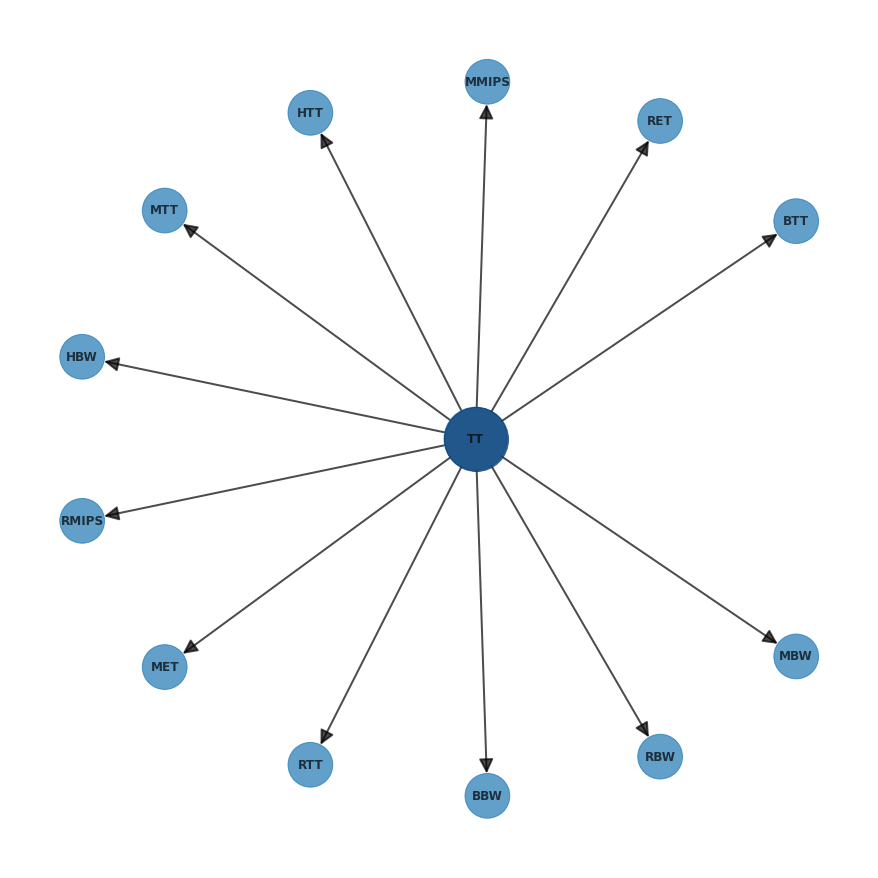

In [14]:
plt.figure(3,figsize=(12,12)) 

G = nx.DiGraph()
G.add_edges_from(bayes_model.edges)
G.add_nodes_from(bayes_model.nodes)
pos = nx.kamada_kawai_layout(G)
nx.draw(G,
                pos=pos,
                with_labels=True,
                node_size=[4000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000],
                arrowsize=30,
                alpha=0.7,
                font_weight="bold",
                width=2.0)  # Draw the original graph

tt_g = G.subgraph(nodes=['TT'])
nx.draw(tt_g, pos=pos, with_labels=False, arrowsize=0, node_size=4100, alpha=0.7, font_weight="bold", node_color='#063970')

plt.show()

In [15]:
bayes_model.get_cpds()

[<TabularCPD representing P(TT:4) at 0x1f0fd526aa0>,
 <TabularCPD representing P(BTT:2 | TT:4) at 0x1f0fd527430>,
 <TabularCPD representing P(RET:2 | TT:4) at 0x1f0fd54a590>,
 <TabularCPD representing P(MMIPS:4 | TT:4) at 0x1f0fd526800>,
 <TabularCPD representing P(HTT:2 | TT:4) at 0x1f0fd5264a0>,
 <TabularCPD representing P(MTT:4 | TT:4) at 0x1f0fd54afb0>,
 <TabularCPD representing P(HBW:2 | TT:4) at 0x1f0fd527c10>,
 <TabularCPD representing P(RMIPS:4 | TT:4) at 0x1f0fd527490>,
 <TabularCPD representing P(MET:4 | TT:4) at 0x1f0fd526500>,
 <TabularCPD representing P(RTT:3 | TT:4) at 0x1f0fd54afe0>,
 <TabularCPD representing P(BBW:2 | TT:4) at 0x1f0fd5819c0>,
 <TabularCPD representing P(RBW:3 | TT:4) at 0x1f0fd5839d0>,
 <TabularCPD representing P(MBW:4 | TT:4) at 0x1f0fd54b370>]

In [16]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

accuracy_dict = {}

for column in testing_data:
    predict_data = testing_data.copy()
    predict_data.drop(column, axis=1, inplace=True)
    y_pred = model.predict(predict_data)

    accuracy = accuracy_score(testing_data[column], y_pred)
    
    # if len(testing_data[column].unique()) == 2:
    #     precision = precision_score(testing_data[column], y_pred, pos_label='High') #pos_label=testing_data[column].unique()
    #     f1 = f1_score(testing_data[column], y_pred, pos_label='High')
    #     recall = recall_score(testing_data[column], y_pred, pos_label='High')

    # else:
    #     precision = precision_score(testing_data[column], y_pred, average='micro') #pos_label=testing_data[column].unique()
    #     f1 = f1_score(testing_data[column], y_pred, average='micro')
    #     recall = recall_score(testing_data[column], y_pred, average='micro')

    #print(f'{column} F1 score: {f1}')
    print(f'{column} Accuracy score: {accuracy}')
    #print(f'{column} Precision score: {precision}')
    #print(f'{column} Recall score: {recall}')

    accuracy_dict[column] = accuracy

  0%|          | 0/166 [00:00<?, ?it/s]

HBW Accuracy score: 0.610236220472441


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/168 [00:00<?, ?it/s]

HTT Accuracy score: 0.6062992125984252


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/157 [00:00<?, ?it/s]

MMIPS Accuracy score: 0.43503937007874016


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/160 [00:00<?, ?it/s]

MET Accuracy score: 0.43700787401574803


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/153 [00:00<?, ?it/s]

MBW Accuracy score: 0.8326771653543307


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/114 [00:00<?, ?it/s]

MTT Accuracy score: 0.4645669291338583


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/151 [00:00<?, ?it/s]

RMIPS Accuracy score: 0.6614173228346457


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/169 [00:00<?, ?it/s]

RET Accuracy score: 0.8228346456692913


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/169 [00:00<?, ?it/s]

RBW Accuracy score: 0.7480314960629921


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/159 [00:00<?, ?it/s]

RTT Accuracy score: 0.6161417322834646


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/169 [00:00<?, ?it/s]

BBW Accuracy score: 0.8976377952755905


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/169 [00:00<?, ?it/s]

BTT Accuracy score: 0.797244094488189


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


  0%|          | 0/151 [00:00<?, ?it/s]

TT Accuracy score: 0.7677165354330708


c:\Python310\lib\site-packages\pgmpy\models\BayesianNetwork.py:747: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return data.merge(data_with_results, how="left").loc[:, missing_variables]


In [17]:
f1 = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=bayes_model, data=testing_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=bayes_model, data=testing_data)
ss = structure_score(model=bayes_model, data=testing_data, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Strcture score: {ss}')

F1 score: 0.0
Accuracy score: 0.6282051282051282
Precision score: 0.0
Recall score: 0.0
Log-likilihood score: -5130.474320131481
Strcture score: -5313.968818819015


c:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
def store_metrics(metrics_file_name, model_name, f1, accuracy, precision, recall, log_likelihood_score, structure_score, accuracy_dict):
    try: 
        df = pd.read_csv('Model-metrics.csv', header=0, index_col=False)
    except:
        df_columns = ['Model', 'F1', 'Accuracy', 'Precision', 'Recall', 'Log likelihood score', 'Structure score']

        df = pd.DataFrame(columns=df_columns)

    else:
        df = df[df.Model != model_name]
        
    conv_dict = {}
    for k, v in accuracy_dict.items():
        conv_dict[k] = v*100
    
    new_row = {'Model': model_name, 'F1': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Log likelihood score': log_likelihood_score, 'Structure score': structure_score,
    'HBW prediction accuracy': conv_dict['HBW'], 'HTT prediction accuracy': conv_dict['HTT'], 'MMIPS prediction accuracy': conv_dict['MMIPS'], 'MET prediction accuracy': conv_dict['MET'],
    'MBW prediction accuracy': conv_dict['MBW'], 'MTT prediction accuracy': conv_dict['MTT'], 'RMIPS prediction accuracy': conv_dict['RMIPS'], 'RET prediction accuracy': conv_dict['RET'],
    'RBW prediction accuracy': conv_dict['RBW'], 'RTT prediction accuracy': conv_dict['RTT'], 'BBW prediction accuracy': conv_dict['BBW'], 'BTT prediction accuracy': conv_dict['BTT'],
    'TT prediction accuracy': conv_dict['TT']}

    df = df.append(new_row, ignore_index=True)

    # Write to file
    df.to_csv(metrics_file_name, index=False)


In [19]:
model_name = 'Naive Bayes'
metrics_file_name = 'Model-metrics.csv'

store_metrics(metrics_file_name=metrics_file_name, model_name=model_name, f1=f1, accuracy=acc, precision=pr, recall=recall, log_likelihood_score=ls, structure_score=ss, accuracy_dict=accuracy_dict)

C:\Users\KEIRMC~1\AppData\Local\Temp/ipykernel_1924/2030668363.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [20]:
print(f'Check model: {bayes_model.check_model()}\n')
for cpd in bayes_model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

Check model: True

CPT of TT:
+-------+-----------+
| TT(1) | 0.0929062 |
+-------+-----------+
| TT(2) | 0.392857  |
+-------+-----------+
| TT(3) | 0.350147  |
+-------+-----------+
| TT(4) | 0.164089  |
+-------+-----------+ 

CPT of BTT:
+--------+---------------------+-----+---------------------+
| TT     | TT(1)               | ... | TT(4)               |
+--------+---------------------+-----+---------------------+
| BTT(1) | 0.5686922060766182  | ... | 0.07367240089753178 |
+--------+---------------------+-----+---------------------+
| BTT(4) | 0.43130779392338175 | ... | 0.9263275991024682  |
+--------+---------------------+-----+---------------------+ 

CPT of RET:
+--------+-----------------------+-----+----------------------+
| TT     | TT(1)                 | ... | TT(4)                |
+--------+-----------------------+-----+----------------------+
| RET(1) | 0.9966974900924703    | ... | 0.016828721017202692 |
+--------+-----------------------+-----+---------------------